# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam, NAdam
from tqdm import tqdm
import scipy.io
import sys
import os

from functions import *
from util import *
from module import *
sys.path.append("../..")


import scipy.io
from scipy.spatial import distance
import time
#from add_on import *
#import sobol_seq
from pyDOE import lhs

from torchmin import ScipyMinimizer, Minimizer

# Loss history definition

# Seed initialization

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda'

# Class definition

In [3]:
class PhysicsInformedNN(nn.Module):
    # =============================================================================
    #       Chen, Zhao, Yang Liu, and Hao Sun. "Physics-informed learning of governing equations from scarce data." 
    #       arXiv preprint arXiv:2005.03448 (2020).
    # =============================================================================

    def __init__(self, X, u, v, X_f, X_val, u_val, v_val, lb, ub, layers, BatchNo):

        super().__init__()
        self.lb = lb.astype(np.float32)
        self.ub = ub.astype(np.float32)

        # Initialize NNs
        self.model = MLP(layers, self.lb, self.ub).to(device)


        




        self.lambda_u = torch.nn.Parameter(torch.tensor(np.zeros((110, 1), np.float32), dtype=torch.float32, requires_grad=True).to(device))
        self.lambda_v = torch.nn.Parameter(torch.tensor(np.zeros((110, 1), np.float32), dtype=torch.float32, requires_grad=True).to(device))


        var_list_1 = list(self.model.parameters())

        var_list_Pretrain = list(self.model.parameters())
        var_list_Pretrain.append(self.lambda_u)
        var_list_Pretrain.append(self.lambda_v)

        ######### Training data ################
        self.x = torch.tensor(X[:,0:1], dtype=torch.float32, requires_grad=True).to(device)
        self.y = torch.tensor(X[:,1:2], dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(X[:,2:3], dtype=torch.float32, requires_grad=True).to(device)
        self.u = torch.tensor(u, dtype=torch.float32, requires_grad=True).to(device)
        self.v = torch.tensor(v, dtype=torch.float32, requires_grad=True).to(device)


        # Collocation points 
        self.x_f = torch.tensor(X_f[:,0:1], dtype=torch.float32, requires_grad=True).to(device)
        self.y_f = torch.tensor(X_f[:,1:2], dtype=torch.float32, requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:,2:3], dtype=torch.float32, requires_grad=True).to(device)
        
        self.BatchNo = BatchNo
        self.batchsize_train = np.floor(self.x.size()[0]/self.BatchNo)
        self.batchsize_f = np.floor(self.x_f.size()[0]/self.BatchNo) 


        # self.x_tf = tf.tensor(tf.float32, shape=[None, self.x.shape[1]])
        # self.y_tf = tf.tensor(tf.float32, shape=[None, self.y.shape[1]])
        # self.t_tf = tf.tensor(tf.float32, shape=[None, self.t.shape[1]])
        # self.u_tf = tf.tensor(tf.float32, shape=[None, self.u.shape[1]])
        # self.v_tf = tf.tensor(tf.float32, shape=[None, self.v.shape[1]])
        # self.x_f_tf = tf.tensor(tf.float32, shape=[None, self.x_f.shape[1]], name = 'x_f_tf')
        # self.y_f_tf = tf.tensor(tf.float32, shape=[None, self.y_f.shape[1]])
        # self.t_f_tf = tf.tensor(tf.float32, shape=[None, self.t_f.shape[1]])

        # self.u_pred, self.v_pred = self.net_uv(self.x, self.y, self.t)
        # self.f_u_pred, self.f_v_pred, self.Phi, self.u_t_pred, self.v_t_pred = self.net_f(self.x_f, self.y_f, self.t_f,
        #                                                                                           self.batchsize_f)

        # self.loss_u = torch.mean((self.u - self.u_pred) ** 2)
        # self.loss_v = torch.mean((self.v - self.v_pred) ** 2)

        self.loss_f_coeff = 10

        # self.loss_f_u = self.loss_f_coeff * torch.mean((self.f_u_pred) ** 2)
        # self.loss_f_v = self.loss_f_coeff * torch.mean((self.f_v_pred) ** 2)

        # self.loss_lambda_u = 1e-7 * torch.linalg.vector_norm(self.lambda_u, ord=1)
        # self.loss_lambda_v = 1e-7 * torch.linalg.vector_norm(self.lambda_v, ord=1)

        # self.loss = torch.log(self.loss_u + self.loss_v + self.loss_f_u + self.loss_f_v + self.loss_lambda_u + self.loss_lambda_v) 

         ######### Validation data ################
        self.x_val = torch.tensor(X_val[:,0:1], dtype=torch.float32, requires_grad=True).to(device)
        self.y_val = torch.tensor(X_val[:,1:2], dtype=torch.float32, requires_grad=True).to(device)
        self.t_val = torch.tensor(X_val[:,2:3], dtype=torch.float32, requires_grad=True).to(device)
        self.u_val = torch.tensor(u_val, dtype=torch.float32, requires_grad=True).to(device)
        self.v_val = torch.tensor(v_val, dtype=torch.float32, requires_grad=True).to(device)
        
        self.batchsize_val = np.floor(self.x_val.size()[0]/self.BatchNo)


        # self.u_val_pred, self.v_val_pred = self.net_uv(self.x_val, self.y_val, self.t_val)

        # self.loss_u_val = torch.mean((self.u_val - self.u_val_pred) ** 2)
        # self.loss_v_val = toch.mean((self.v_val - self.v_val_pred) ** 2)


        ######### Optimizer #########################
        options = {'maxiter': 1000, 'maxfun': 1000,
                                    'maxcor': 50,
                                    'maxls': 50,
                                    'ftol' : 0.1 * np.finfo(float).eps,
                                    'disp': True}
        
        options_Pretrain = {'maxiter': 12_700,'maxfun': 12_700,
                                              'maxcor': 50,
                                              'maxls': 50,
                                              'ftol' : 0.1 * np.finfo(float).eps,
                                              'disp': True}
        
        self.optmizer = ScipyMinimizer(var_list_1, method = 'L-BFGS-B', options=options)
        self.optimizer_Pretrain = ScipyMinimizer(var_list_Pretrain, method = 'L-BFGS-B', options=options_Pretrain)
        
        # self.optmizer = Minimizer(var_list_1, method = 'L-BFGS')
        # self.optimizer_Pretrain = Minimizer(var_list_Pretrain, method = 'L-BFGS')
        
        # self.optimizer = LBFGS(var_list_1, line_search_fn='strong_wolfe')
        # self.optimizer_Pretrain = LBFGS(var_list_Pretrain, line_search_fn='strong_wolfe')

        self.optimizer_Adam = NAdam(var_list_1, lr = 1e-3)

        self.optimizer_Adam_Pretrain = NAdam(var_list_Pretrain, lr = 5e-3)



    def net_uv(self, x, y, t): 

        u_v = self.model(torch.cat((x, y, t), dim=1))
        u = u_v[:, 0:1]
        v = u_v[:, 1:2]

        # psi_and_p = self.model(x, y, t)
        # psi = psi_and_p[:,:,0:1]
        # p = psi_and_p[:,:,1:2]

        # u = torch.autograd.grad(psi, y_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        # v = - torch.autograd.grad(psi, x_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

        return u,v 

    def predict(self, X_star):

        x = torch.tensor(X_star[:,0:1], dtype=torch.float32).to(device)
        y = torch.tensor(X_star[:,0:1], dtype=torch.float32).to(device)
        t = torch.tensor(X_star[:,0:1], dtype=torch.float32).to(device)
        u_v = self.model(torch.cat((x, y, t), dim=1))
        u = u_v[:, 0:1].cpu().detach().numpy()[:,0]
        v = u_v[:, 1:2].cpu().detach().numpy()[:,0]

        return u,v

    def get_derivatives(self, f, x):
        f_x = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), retain_graph=True, create_graph=True)[0]
        f_xx = torch.autograd.grad(f_x, x, grad_outputs=torch.ones_like(f_x), retain_graph=True, create_graph=True)[0]
        
        return f_x, f_xx
    def net_f(self, x, y, t, N_f):

        u, v = self.net_uv(x, y, t)
        data = [u,v]
        # print("-----------------")
        # print(f"u[:,0] size {u[:,0].size()}")
        # print("-----------------")


        ## derivatives     
        u_x, u_xx = self.get_derivatives(u, x)
        u_y, u_yy = self.get_derivatives(u, y)
        u_xy, _ = self.get_derivatives(u_x, y)
        u_t, _ = self.get_derivatives(u, t)
        
        
        v_x, v_xx = self.get_derivatives(v, x)
        v_y, v_yy = self.get_derivatives(v, y)
        v_xy, _ = self.get_derivatives(v_x, y)
        v_t, _ = self.get_derivatives(v, t)

        derivatives = [1]
        derivatives.append(u_x)
        derivatives.append(u_xx)
        derivatives.append(u_y)
        derivatives.append(u_yy)
        derivatives.append(u_xy)
        derivatives.append(v_x)
        derivatives.append(v_xx)
        derivatives.append(v_y)
        derivatives.append(v_yy)
        derivatives.append(v_xy)
        
        derivatives_description = ['', 'u_{x}', 'u_{xx}', 'u_{y}','u_{yy}','u_{xy}','v_{x}', 'v_{xx}', 'v_{y}','v_{yy}','v_{xy}']
        


        global lib_fun
        global lib_descr
        lib_fun, lib_descr = build_library(data, derivatives, derivatives_description, PolyOrder = 3, 
                                                data_description = ['u','v'])     

        f_u = u_t
        f_v = v_t
        Phi = torch.ones((N_f.astype(np.int32), 1), dtype=torch.float32).to(device)#, requires_grad=True)
        for i in range(len(lib_fun)):
            # print("-----------------")
            # print(f"self.lambda_u[i:i+1,0:1] {self.lambda_u[i:i+1,0:1].size()}")
            # print(f" f_u size {f_u.size()}")
            # print(f_u, lib_fun[i], self.lambda_u[i:i+1,0:1])
            f_u = f_u - lib_fun[i]*self.lambda_u[i:i+1,0:1] # Note that the minus sign instead of the plus sign is uesd here.
            f_v = f_v - lib_fun[i]*self.lambda_v[i:i+1,0:1] # Note that the minus sign instead of the plus sign is uesd here.
            if i != 0:

                
                Phi = torch.cat((Phi, lib_fun[i]), dim=1)

        # print('-------------------------------------------------------')        
        # print(f"f_u {f_u.size()}, f_v {f_v.size()}, Phi {Phi.size()}, u_t {u_t.size()}, v_t {v_t.size()}")
                                            
        return f_u, f_v, Phi, u_t, v_t




    def loss_function(self, x, y, t, u, v, x_f, y_f, t_f, x_val, y_val, t_val, u_val, v_val):

        self.u_pred, self.v_pred = self.net_uv(x, y, t)
        self.f_u_pred, self.f_v_pred, self.Phi, self.u_t_pred, self.v_t_pred = self.net_f(x_f, y_f, t_f,
                                                                                  self.batchsize_f)
        self.loss_u = torch.mean((u - self.u_pred) ** 2)
        self.loss_v = torch.mean((v - self.v_pred) ** 2)


        self.loss_f_u = self.loss_f_coeff * torch.mean((self.f_u_pred) ** 2)
        self.loss_f_v = self.loss_f_coeff * torch.mean((self.f_v_pred) ** 2)

        self.loss_lambda_u = 1e-7 * torch.linalg.vector_norm(self.lambda_u, ord=1)
        self.loss_lambda_v = 1e-7 * torch.linalg.vector_norm(self.lambda_v, ord=1)
        # print("--------------------------")
        # print(self.loss_lambda_u.size(), self.loss_lambda_v.size(), self.loss_u.size())

        self.loss = torch.log(self.loss_u + self.loss_v + self.loss_f_u + self.loss_f_v + self.loss_lambda_u + self.loss_lambda_v) 
       
        self.u_val_pred, self.v_val_pred = self.net_uv(x_val, y_val, t_val)

        self.loss_u_val = torch.mean((u_val - self.u_val_pred) ** 2)
        self.loss_v_val = torch.mean((v_val - self.v_val_pred) ** 2)
        self.loss_val = torch.log(self.loss_u_val  + self.loss_v_val)




    def Pretrain(self):       
        # Dictionary        
                    
        # With batches
        for i in range(self.BatchNo):                
            x_batch = self.x[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            y_batch = self.y[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            t_batch = self.t[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            u_batch = self.u[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            v_batch = self.v[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            
            x_f_batch = self.x_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f)]
            y_f_batch = self.y_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f)]
            t_f_batch = self.t_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f)]
            
            x_val_batch = self.x_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val)]
            y_val_batch = self.y_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val)]
            t_val_batch = self.t_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val)]
            u_val_batch = self.u_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            v_val_batch = self.v_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            


            # Adam optimizer(Pretraining)
            print('Adam(Pretraining) starts')
            start_time = time.time()
            for it_Adam in range(100): #10_000

                def closure():
                    # self.u_pred, self.v_pred = self.net_uv(x_batch, y_batch, t_batch)
                    # self.f_u_pred, self.f_v_pred, self.Phi, self.u_t_pred, self.v_t_pred = self.net_f(x_f_batch, y_f_batch, t_f_batch,
                    #                                                                           self.batchsize_f)
                    # self.loss_u = torch.mean((self.u - self.u_pred[:,0]) ** 2)
                    # self.loss_v = torch.mean((self.v - self.v_pred[:,0]) ** 2)


                    # self.loss_f_u = self.loss_f_coeff * torch.mean((self.f_u_pred) ** 2)
                    # self.loss_f_v = self.loss_f_coeff * torch.mean((self.f_v_pred) ** 2)

                    # self.loss_lambda_u = 1e-7 * torch.linalg.vector_norm(self.lambda_u, ord=1)
                    # self.loss_lambda_v = 1e-7 * torch.linalg.vector_norm(self.lambda_v, ord=1)

                    # self.loss = torch.log(self.loss_u + self.loss_v + self.loss_f_u + self.loss_f_v + self.loss_lambda_u + self.loss_lambda_v) 
                   
                    # self.u_val_pred, self.v_val_pred = self.net_uv(x_val_batch, y_val_batch, t_val_batch)

                    # self.loss_u_val = torch.mean((self.u_val - self.u_val_pred[:,0]) ** 2)
                    # self.loss_v_val = torch.mean((self.v_val - self.v_val_pred[:,0]) ** 2)
                    # self.loss_val = torch.log(self.loss_u_val  + self.loss_v_val) 

                    
                    self.loss_function(x_batch, y_batch, t_batch, u_batch, v_batch, x_f_batch, y_f_batch, t_f_batch, x_val_batch, y_val_batch, t_val_batch, u_val_batch, v_val_batch)
                    self.optimizer_Adam_Pretrain.zero_grad()
                    self.loss.backward()
                    return self.loss
                       

                self.optimizer_Adam_Pretrain.step(closure)    
                
                # Print
                if it_Adam % 10 == 0:
                    elapsed = time.time() - start_time
                    # loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, lambda_u, lambda_v, loss_val = \
                    #     self.sess.run([self.loss, self.loss_u, self.loss_v, self.loss_f_u, self.loss_f_v, self.loss_lambda_u, 
                    #                    self.loss_lambda_v, self.lambda_u, self.lambda_v, self.loss_val], self.tf_dict)
                    print('It: %d, Log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, loss_val: %e, Time: %.2f' 
                          % (it_Adam, self.loss.item(), self.loss_u.item(), self.loss_v.item(), self.loss_f_u.item(), self.loss_f_v.item(), self.loss_lambda_u.item(), 
                          self.loss_lambda_v.item(), self.loss_val.item(), elapsed))
                    
                    global loss_history_Adam_Pretrain
                    global loss_val_history_Adam_Pretrain
                    global lambda_u_history_Adam_Pretrain
                    global lambda_v_history_Adam_Pretrain
                    global loss_u_history_Adam_Pretrain
                    global loss_v_history_Adam_Pretrain
                    global loss_f_u_history_Adam_Pretrain
                    global loss_f_v_history_Adam_Pretrain
                    global loss_lambda_u_history_Adam_Pretrain  
                    global loss_lambda_v_history_Adam_Pretrain
                    
                    loss_history_Adam_Pretrain = np.append(loss_history_Adam_Pretrain, self.loss.item())
                    loss_val_history_Adam_Pretrain = np.append(loss_val_history_Adam_Pretrain, self.loss_val.item())
                    lambda_u_history_Adam_Pretrain = np.append(lambda_u_history_Adam_Pretrain, self.lambda_u.cpu().detach().numpy(), axis=1)
                    lambda_v_history_Adam_Pretrain = np.append(lambda_v_history_Adam_Pretrain, self.lambda_v.cpu().detach().numpy(), axis=1)
                    loss_u_history_Adam_Pretrain = np.append(loss_u_history_Adam_Pretrain, self.loss_u.item())
                    loss_v_history_Adam_Pretrain = np.append(loss_v_history_Adam_Pretrain, self.loss_v.item())
                    loss_f_u_history_Adam_Pretrain = np.append(loss_f_u_history_Adam_Pretrain, self.loss_f_u.item())
                    loss_f_v_history_Adam_Pretrain = np.append(loss_f_v_history_Adam_Pretrain, self.loss_f_v.item())
                    loss_lambda_u_history_Adam_Pretrain = np.append(loss_lambda_u_history_Adam_Pretrain, self.loss_lambda_u.item())
                    loss_lambda_v_history_Adam_Pretrain = np.append(loss_lambda_v_history_Adam_Pretrain, self.loss_lambda_v.item())
            
                    start_time = time.time()

            print('\nL-BFGS-B(Pretraining) starts')
            start_time = time.time()
            for it_lbfgs in range(1): #40_000
                prev_loss = None
                tolerance = 0.1 * np.finfo(float).eps # Set your desired tolerance here

                def closure():
                    
                    
                    self.loss_function(x_batch, y_batch, t_batch, u_batch, v_batch, x_f_batch, y_f_batch, t_f_batch, x_val_batch, y_val_batch, t_val_batch, u_val_batch, v_val_batch)
                    self.optimizer_Pretrain.zero_grad()
                    self.loss.backward(retain_graph=True)
                    return self.loss 

                self.optimizer_Pretrain.step(closure)  

                if it_lbfgs % 10 == 0:
                    elapsed = time.time() - start_time
                    #### print out to files
                    print('It: %d, log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, log loss_val: %e, Time: %.2f' % 
                          (it_lbfgs, self.loss.item(), self.loss_u.item(), self.loss_v.item(), self.loss_f_u.item(), self.loss_f_v.item(), self.loss_lambda_u.item(), 
                              self.loss_lambda_v.item(), self.loss_val.item(), elapsed))
                    
                    global loss_history_Pretrain
                    global loss_val_history_Pretrain
                    global lambda_u_history_Pretrain
                    global lambda_v_history_Pretrain
                    global loss_u_history_Pretrain
                    global loss_v_history_Pretrain
                    global loss_f_u_history_Pretrain
                    global loss_f_v_history_Pretrain
                    global loss_lambda_u_history_Pretrain
                    global loss_lambda_v_history_Pretrain
                    
                    loss_history_Pretrain = np.append(loss_history_Pretrain, self.loss.item())
                    loss_val_history_Pretrain = np.append(loss_val_history_Pretrain, self.loss_val.item())
                    lambda_u_history_Pretrain = np.append(lambda_u_history_Pretrain, self.lambda_u.cpu().detach().numpy(), axis=1)
                    lambda_v_history_Pretrain = np.append(lambda_v_history_Pretrain, self.lambda_v.cpu().detach().numpy(), axis=1)
                    loss_u_history_Pretrain = np.append(loss_u_history_Pretrain, self.loss_u.item())
                    loss_v_history_Pretrain = np.append(loss_v_history_Pretrain, self.loss_v.item())
                    loss_f_u_history_Pretrain = np.append(loss_f_u_history_Pretrain, self.loss_f_u.item())
                    loss_f_v_history_Pretrain = np.append(loss_f_v_history_Pretrain, self.loss_f_v.item())
                    loss_lambda_u_history_Pretrain = np.append(loss_lambda_u_history_Pretrain, self.loss_lambda_u.item())
                    loss_lambda_v_history_Pretrain = np.append(loss_lambda_v_history_Pretrain, self.loss_lambda_v.item())
                    start_time = time.time()
                    
                    
    def callback_Pretrain(self, loss, lambda_u, lambda_v, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v,
                          loss_val):
        global step_Pretrain
        step_Pretrain += 1
        if step_Pretrain % 10 == 0:
            #### print out to files
            print('It: %d, log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, log loss_val: %e' % 
                  (it_lbfgs, self.loss.item(), self.loss_u.item(), self.loss_v.item(), self.loss_f_u.item(), self.loss_f_v.item(), self.loss_lambda_u.item(), 
                      self.loss_lambda_v.item(), self.loss_val.item()))
                  
            global loss_history_Pretrain
            global loss_val_history_Pretrain
            global lambda_u_history_Pretrain
            global lambda_v_history_Pretrain
            global loss_u_history_Pretrain
            global loss_v_history_Pretrain
            global loss_f_u_history_Pretrain
            global loss_f_v_history_Pretrain
            global loss_lambda_u_history_Pretrain
            global loss_lambda_v_history_Pretrain

            loss_history_Pretrain = np.append(loss_history_Pretrain, self.loss.item())
            loss_val_history_Pretrain = np.append(loss_val_history_Pretrain, self.loss_val.item())
            lambda_u_history_Pretrain = np.append(lambda_u_history_Pretrain, self.lambda_u.cpu().detach().numpy(), axis=1)
            lambda_v_history_Pretrain = np.append(lambda_v_history_Pretrain, self.lambda_v.cpu().detach().numpy(), axis=1)
            loss_u_history_Pretrain = np.append(loss_u_history_Pretrain, self.loss_u.item())
            loss_v_history_Pretrain = np.append(loss_v_history_Pretrain, self.loss_v.item())
            loss_f_u_history_Pretrain = np.append(loss_f_u_history_Pretrain, self.loss_f_u.item())
            loss_f_v_history_Pretrain = np.append(loss_f_v_history_Pretrain, self.loss_f_v.item())
            loss_lambda_u_history_Pretrain = np.append(loss_lambda_u_history_Pretrain, self.loss_lambda_u.item())
            loss_lambda_v_history_Pretrain = np.append(loss_lambda_v_history_Pretrain, self.loss_lambda_v.item())

    def ADO(self, nIter):
        # With batches
        for i in range(self.BatchNo):                
            x_batch = self.x[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            y_batch = self.y[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            t_batch = self.t[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            u_batch = self.u[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            v_batch = self.v[int(i*self.batchsize_train):int((i+1)*self.batchsize_train), :]
            
            x_f_batch = self.x_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
            y_f_batch = self.y_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
            t_f_batch = self.t_f[int(i*self.batchsize_f):int((i+1)*self.batchsize_f), :]
            
            x_val_batch = self.x_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            y_val_batch = self.y_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            t_val_batch = self.t_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            u_val_batch = self.u_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            v_val_batch = self.v_val[int(i*self.batchsize_val):int((i+1)*self.batchsize_val), :]
            

            for self.it in range(nIter):    
                
                # STRidge optimizer
                print('STRidge starts')
                _, _, Phi, u_t_pred, v_t_pred = self.net_f(x_f_batch, y_f_batch, t_f_batch, self.batchsize_f) 
                self.lambda_u, self.lambda_v = callTrainSTRidge(x_f_batch, y_f_batch, t_f_batch, Phi, u_t_pred, v_t_pred, self.lambda_u, self.lambda_v, it=self.it)
                
                self.lambda_u = torch.nn.Parameter(self.lambda_u.to(device))
                self.lambda_v = torch.nn.Parameter(self.lambda_v.to(device))

                # Adam optimizer                
                print('Adam starts')
                start_time = time.time()
                for it_Adam in range(1_000): # 1_000
                    def closure():
                        self.optimizer_Adam.zero_grad()
                        self.loss_function(x_batch, y_batch, t_batch, u_batch, v_batch, x_f_batch, y_f_batch, t_f_batch, x_val_batch, y_val_batch, t_val_batch, u_val_batch, v_val_batch)
                        self.loss.backward()
                        return self.loss
                           

                    self.optimizer_Adam.step(closure)  
                    
                    # Print
                    if it_Adam % 10 == 0:
                        elapsed = time.time() - start_time

                        print('It: %d, Log Loss: %e, loss_u: %e, loss_v: %e, loss_f_u: %e, loss_f_v: %e, loss_lambda_u: %e, loss_lambda_v: %e, loss_val: %e, Time: %.2f' 
                              % (it_Adam, self.loss.item(), self.loss_u.item(), self.loss_v.item(), self.loss_f_u.item(), self.loss_f_v.item(), self.loss_lambda_u.item(), 
                              self.loss_lambda_v.item(), self.loss_val.item(), elapsed))
                        
                        global loss_history_Adam
                        global loss_val_history_Adam
                        global lambda_u_history_Adam
                        global lambda_v_history_Adam
                        global loss_u_history_Adam
                        global loss_v_history_Adam
                        global loss_f_u_history_Adam
                        global loss_f_v_history_Adam
                        global loss_lambda_u_history_Adam
                        global loss_lambda_v_history_Adam
                        
                        loss_history_Adam = np.append(loss_history_Adam, self.loss.item())
                        loss_val_history_Adam = np.append(loss_val_history_Adam, self.loss_val.item())
                        lambda_u_history_Adam = np.append(lambda_u_history_Adam, self.lambda_u.cpu().detach().numpy(), axis=1)
                        lambda_v_history_Adam = np.append(lambda_v_history_Adam, self.lambda_v.cpu().detach().numpy(), axis=1)
                        loss_u_history_Adam = np.append(loss_u_history_Adam, self.loss_u.item())
                        loss_v_history_Adam = np.append(loss_v_history_Adam, self.loss_v.item())
                        loss_f_u_history_Adam = np.append(loss_f_u_history_Adam, self.loss_f_u.item())
                        loss_f_v_history_Adam = np.append(loss_f_v_history_Adam, self.loss_f_v.item())
                        loss_lambda_u_history_Adam = np.append(loss_lambda_u_history_Adam, self.loss_lambda_u.item())
                        loss_lambda_v_history_Adam = np.append(loss_lambda_v_history_Adam, self.loss_lambda_v.item())
                
                        start_time = time.time()
                        
                    # if it_Adam == 999:
                    #     loss, loss_u, loss_v, loss_f_u, loss_f_v, loss_lambda_u, loss_lambda_v, lambda_u, lambda_v, loss_val = \
                    #         self.sess.run([self.loss, self.loss_u, self.loss_v, self.loss_f_u, self.loss_f_v, self.loss_lambda_u, 
                    #                        self.loss_lambda_v, self.lambda_u, self.lambda_v, self.loss_val], self.tf_dict)
                        
                    #     global loss_history_Alter
                    #     global loss_val_history_Alter
                    #     global lambda_u_history_Alter
                    #     global lambda_v_history_Alter
                    #     global loss_u_history_Alter
                    #     global loss_v_history_Alter
                    #     global loss_f_u_history_Alter
                    #     global loss_f_v_history_Alter
                    #     global loss_lambda_u_history_Alter
                    #     global loss_lambda_v_history_Alter
                        
                    #     loss_history_Alter = np.append(loss_history_Alter, loss)
                    #     loss_val_history_Alter = np.append(loss_val_history_Alter, loss_val)
                    #     lambda_u_history_Alter = np.append(lambda_u_history_Alter, lambda_u, axis=1)
                    #     lambda_v_history_Alter = np.append(lambda_v_history_Alter, lambda_v, axis=1)
                    #     loss_u_history_Alter = np.append(loss_u_history_Alter, loss_u)
                    #     loss_v_history_Alter = np.append(loss_v_history_Alter, loss_v)
                    #     loss_f_u_history_Alter = np.append(loss_f_u_history_Alter, loss_f_u)
                    #     loss_f_v_history_Alter = np.append(loss_f_v_history_Alter, loss_f_v)
                    #     loss_lambda_u_history_Alter = np.append(loss_lambda_u_history_Alter, loss_lambda_u)
                    #     loss_lambda_v_history_Alter = np.append(loss_lambda_v_history_Alter, loss_lambda_v)
                                                    
                # L-BFGS-B optimizer
                # print('L-BFGS-B starts')
                # self.optimizer.minimize(self.sess,
                #                         feed_dict = self.tf_dict,
                #                         fetches = [self.loss, self.lambda_u, self.lambda_v, self.loss_u, self.loss_v, 
                #                                    self.loss_f_u, self.loss_f_v, self.loss_lambda_u, self.loss_lambda_v, self.loss_val],
                #                         loss_callback = self.callback)

            # STRidge optimizer
            print('STRidge starts')
            _, _, Phi, u_t_pred, v_t_pred = self.net_f(x_f_batch, y_f_batch, t_f_batch, self.batchsize_f) 
            self.lambda_u, self.lambda_v = callTrainSTRidge(x_f_batch, y_f_batch, t_f_batch, Phi, u_t_pred, v_t_pred, self.lambda_u, self.lambda_v, it=self.it)




# Loading data

In [4]:
start_time = time.time()

layers = [3] + 8*[60] + [2]

# =============================================================================
#         load data
# =============================================================================
data = scipy.io.loadmat('reaction_diffusion_standard.mat') # grid 256*256*201

t = np.real(data['t'].flatten()[:,None])
x = np.real(data['x'].flatten()[:,None])
y = np.real(data['y'].flatten()[:,None])
Exact_u = data['u']
Exact_v = data['v']

X, Y, T = np.meshgrid(x, y, t)

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None] 
v_star = Exact_v.flatten()[:,None]              

# Doman bounds

lb = X_star.min(0)
ub = X_star.max(0)   

In [5]:
# Measurements: Spatially random but temporally continuous
N_uv_s = 2_500

# Use these commands when N_uv_s is larger than X.shape[0] or X.shape[1]
idx = np.random.choice(X.shape[0]*X.shape[1], N_uv_s, replace = False)
idx_remainder = idx%(X.shape[0])
idx_s_y = np.floor(idx/(X.shape[0]))
idx_s_y = idx_s_y.astype(np.int32)
idx_idx_remainder = np.where(idx_remainder == 0)[0]
idx_remainder[idx_idx_remainder] = X.shape[0]
idx_s_x = idx_remainder-1            

# Random sample temporally
N_t_s = 15  # Original value is 20Hz.
idx_t = np.random.choice(X.shape[2], N_t_s, replace=False)
idx_t = idx_t.astype(np.int32)

X1 = X[idx_s_x, idx_s_y, :]
X2 = X1[:, idx_t]
Y1 = Y[idx_s_x, idx_s_y, :]
Y2 = Y1[:, idx_t]
T1 = T[idx_s_x, idx_s_y, :]
T2 = T1[:, idx_t]
Exact_u1 = Exact_u[idx_s_x, idx_s_y, :]
Exact_u2 = Exact_u1[:, idx_t]
Exact_v1 = Exact_v[idx_s_x, idx_s_y, :]
Exact_v2 = Exact_v1[:, idx_t]

X_star_meas = np.hstack((X2.flatten()[:,None], Y2.flatten()[:,None],
                          T2.flatten()[:,None]))
u_star_meas = Exact_u2.flatten()[:,None] 
v_star_meas = Exact_v2.flatten()[:,None] 

# Training measurements, which are randomly sampled spatio-temporally
Split_TrainVal = 0.8
N_u_train = int(N_uv_s*N_t_s*Split_TrainVal)
idx_train = np.random.choice(X_star_meas.shape[0], N_u_train, replace=False)
X_star_train = X_star_meas[idx_train,:]
u_star_train = u_star_meas[idx_train,:]
v_star_train = v_star_meas[idx_train,:]

# Validation Measurements, which are the rest of measurements
idx_val = np.setdiff1d(np.arange(X_star_meas.shape[0]), idx_train, assume_unique=True)
X_star_val = X_star_meas[idx_val,:]
u_star_val = u_star_meas[idx_val,:]
v_star_val = v_star_meas[idx_val,:]

In [6]:
# Collocation points
N_f = 80_000  #80_000
#        X_f = lb + (ub-lb)*sobol_seq.i4_sobol_generate(3, N_f)
X_f = lb + (ub-lb)*lhs(3, N_f)
#        X_f = np.vstack((X_f, X_star_train))

# add noise
noise = 0.1
u_star_train = u_star_train + noise*np.std(u_star_train)*np.random.randn(u_star_train.shape[0], u_star_train.shape[1])
v_star_train = v_star_train + noise*np.std(v_star_train)*np.random.randn(v_star_train.shape[0], v_star_train.shape[1])
u_star_val = u_star_val + noise*np.std(u_star_val)*np.random.randn(u_star_val.shape[0], u_star_val.shape[1])
v_star_val = v_star_val + noise*np.std(v_star_val)*np.random.randn(v_star_val.shape[0], v_star_val.shape[1])

BatchNo = 1

X_star_train = X_star_train.astype(np.float32)
u_star_train = u_star_train.astype(np.float32)
v_star_train = v_star_train.astype(np.float32)
X_f = X_f.astype(np.float32)
X_star_val = X_star_val.astype(np.float32)
u_star_val = u_star_val.astype(np.float32)
v_star_val = v_star_val.astype(np.float32)

X_star = X_star.astype(np.float32)


# Pretraining

In [7]:
# =============================================================================
#         train model
# =============================================================================
model = PhysicsInformedNN(X_star_train, u_star_train, v_star_train, X_f, X_star_val, u_star_val, v_star_val, lb, ub, layers, BatchNo)
model.Pretrain()

torch.save(model, 'weights/pretrained_pinn_mlp_sr.pt')

## Checkpoint model        
#        saved_path = model.saver.save(model.sess, './saved_variable')
# print('model saved in {}'.format(saved_path))                

## Restore pretrained model
#        # in case we need to create graph 
# model = PhysicsInformedNN(X_star_train, u_star_train, v_star_train, X_f, X_star_val, u_star_val, v_star_val, layers, lb, ub, BatchNo)
#        # restore the saved vairable
#        model.saver.restore(model.sess, './saved_variable')

Adam(Pretraining) starts
It: 0, Log Loss: -3.947871e-02, loss_u: 4.620309e-01, loss_v: 4.769317e-01, loss_f_u: 1.566168e-02, loss_f_v: 6.666187e-03, loss_lambda_u: 0.000000e+00, loss_lambda_v: 0.000000e+00, loss_val: -6.477728e-02, Time: 1.64
It: 10, Log Loss: -1.149448e-01, loss_u: 4.459609e-01, loss_v: 4.454396e-01, loss_f_u: 4.705167e-06, loss_f_v: 1.006922e-05, loss_lambda_u: 7.538424e-08, loss_lambda_v: 7.485493e-08, loss_val: -1.147655e-01, Time: 2.30
It: 20, Log Loss: -1.150369e-01, loss_u: 4.459165e-01, loss_v: 4.454025e-01, loss_f_u: 1.000972e-05, loss_f_v: 3.909954e-06, loss_lambda_u: 9.669066e-08, loss_lambda_v: 9.676786e-08, loss_val: -1.150306e-01, Time: 2.34
It: 30, Log Loss: -1.119410e-01, loss_u: 4.478699e-01, loss_v: 4.461845e-01, loss_f_u: 1.365071e-05, loss_f_v: 2.867487e-05, loss_lambda_u: 1.079284e-07, loss_lambda_v: 1.053983e-07, loss_val: -1.122064e-01, Time: 2.30
It: 40, Log Loss: -1.150304e-01, loss_u: 4.459072e-01, loss_v: 4.454242e-01, loss_f_u: 4.148568e-06,

 This problem is unconstrained.



At iterate    1    f= -1.15197D-01    |proj g|=  1.36040D-02

At iterate    2    f= -1.15204D-01    |proj g|=  5.11563D-03

At iterate    3    f= -1.15206D-01    |proj g|=  4.43596D-04

At iterate    4    f= -1.15206D-01    |proj g|=  4.27837D-04

At iterate    5    f= -1.15209D-01    |proj g|=  3.31590D-03

At iterate    6    f= -1.15212D-01    |proj g|=  4.04222D-03

At iterate    7    f= -1.15218D-01    |proj g|=  4.20028D-03

At iterate    8    f= -1.15222D-01    |proj g|=  2.33645D-02

At iterate    9    f= -1.15246D-01    |proj g|=  2.05532D-03

At iterate   10    f= -1.15269D-01    |proj g|=  8.23827D-03

At iterate   11    f= -1.15306D-01    |proj g|=  1.94742D-02

At iterate   12    f= -1.15335D-01    |proj g|=  1.29763D-02

At iterate   13    f= -1.15415D-01    |proj g|=  7.27083D-03

At iterate   14    f= -1.15563D-01    |proj g|=  6.36425D-02

At iterate   15    f= -1.15661D-01    |proj g|=  6.94628D-02

At iterate   16    f= -1.15837D-01    |proj g|=  5.43964D-02

At iter

# ADO

In [8]:
model.ADO(6)

torch.save(model, 'weights/final_pinn_mlp_sr.pt')
#        saved_path = model.saver.save(model.sess, './saved_variable_ADO')

STRidge starts


/home/hanqi/Desktop/Ali_Altaher_GOM/Ali_Hycom/3D/pinn/pinnsformer-main/functions.py:388: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
/home/hanqi/Desktop/Ali_Altaher_GOM/Ali_Hycom/3D/pinn/pinnsformer-main/functions.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
/home/hanqi/Desktop/Ali_Altaher_GOM/Ali_Hycom/3D/pinn/pinnsformer-main/functions.py:406: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix 

Adam starts
It: 0, Log Loss: -3.744549e+00, loss_u: 4.649090e-03, loss_v: 4.657843e-03, loss_f_u: 1.446415e-03, loss_f_v: 1.289267e-02, loss_lambda_u: 1.898615e-07, loss_lambda_v: 8.932312e-08, loss_val: -4.663721e+00, Time: 0.41
It: 10, Log Loss: -1.807959e-01, loss_u: 2.248446e-01, loss_v: 1.995611e-01, loss_f_u: 1.648643e-01, loss_f_v: 2.453354e-01, loss_lambda_u: 1.898615e-07, loss_lambda_v: 8.932312e-08, loss_val: -8.813601e-01, Time: 2.27
It: 20, Log Loss: -1.028618e-01, loss_u: 1.418218e-01, loss_v: 1.396645e-01, loss_f_u: 3.881368e-01, loss_f_v: 2.326283e-01, loss_lambda_u: 1.898615e-07, loss_lambda_v: 8.932312e-08, loss_val: -1.267462e+00, Time: 2.27
It: 30, Log Loss: -1.015279e+00, loss_u: 1.368266e-01, loss_v: 1.311733e-01, loss_f_u: 7.111096e-02, loss_f_v: 2.319027e-02, loss_lambda_u: 1.898615e-07, loss_lambda_v: 8.932312e-08, loss_val: -1.335422e+00, Time: 2.26
It: 40, Log Loss: -2.689023e-01, loss_u: 2.668065e-01, loss_v: 2.709558e-01, loss_f_u: 1.296106e-01, loss_f_v: 9.

# Error calculations

In [9]:
# =============================================================================
#         check if training efforts are sufficient
# =============================================================================
elapsed = time.time() - start_time   
f = open("out_data/stdout.txt", "w")                         
f.write('Training time: %.4f \n' % (elapsed))

u_train_pred, v_train_pred = model.predict(X_star_train[:1_000,:])
error_u_train = np.linalg.norm(u_star_train[:1_000,:]-u_train_pred,2)/np.linalg.norm(u_star_train[:1_000,:],2)        
error_v_train = np.linalg.norm(v_star_train[:1_000,:]-v_train_pred,2)/np.linalg.norm(v_star_train[:1_000,:],2)
f.write('Training Error u: %e \n' % (error_u_train))    
f.write('Training Error v: %e \n' % (error_v_train))   

u_val_pred, v_val_pred = model.predict(X_star_val[:1_000,:])
error_u_val = np.linalg.norm(u_star_val[:1_000,:]-u_val_pred,2)/np.linalg.norm(u_star_val[:1_000,:],2)        
error_v_val = np.linalg.norm(v_star_val[:1_000,:]-v_val_pred,2)/np.linalg.norm(v_star_val[:1_000,:],2)
f.write('Val Error u: %e \n' % (error_u_val))    
f.write('Val Error v: %e \n' % (error_v_val))   

27

# Plotting

##  Plots for Adam(Pretraining)

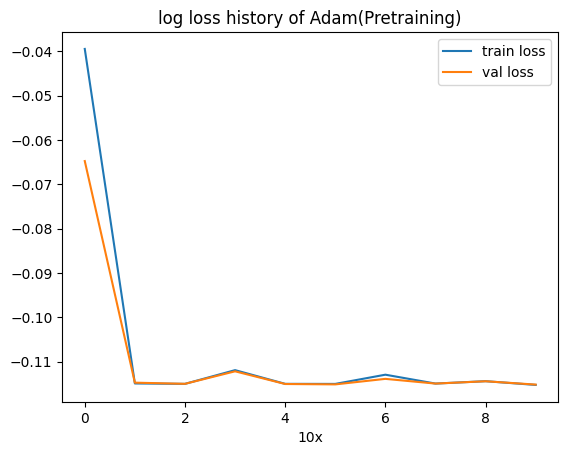

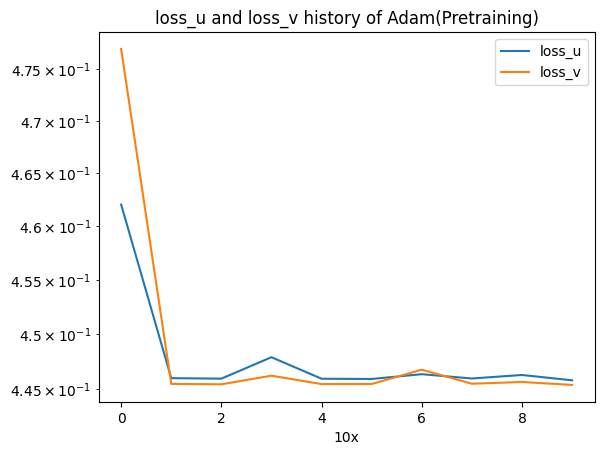

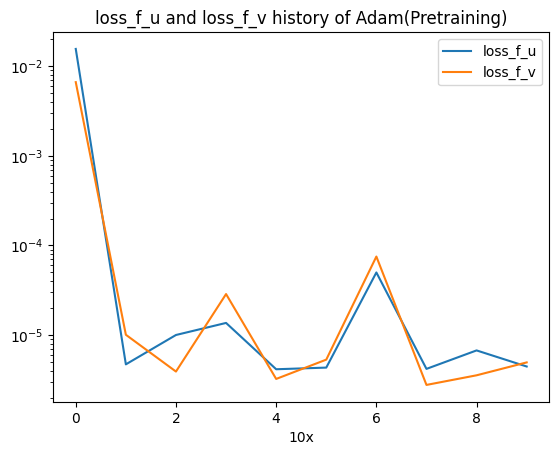

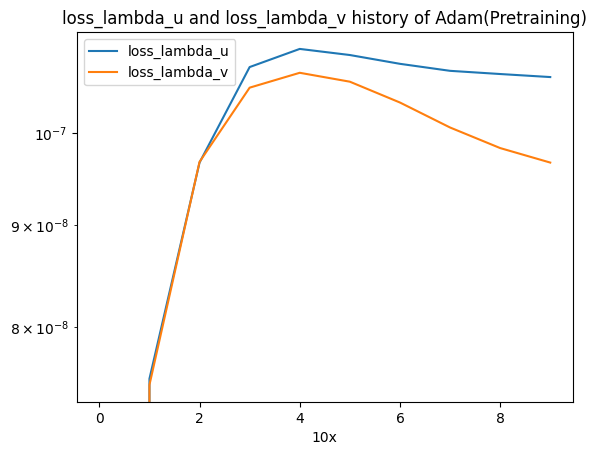

In [10]:
######################## Plots for Adam(Pretraining) #################
fig = plt.figure()
plt.plot(loss_history_Adam_Pretrain)
plt.plot(loss_val_history_Adam_Pretrain)
plt.legend(('train loss', 'val loss'))
plt.xlabel('10x')
plt.title('log loss history of Adam(Pretraining)')
plt.savefig('figures/1.png')

fig = plt.figure()
plt.plot(loss_u_history_Adam_Pretrain)
plt.plot(loss_v_history_Adam_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_u', 'loss_v'))
plt.title('loss_u and loss_v history of Adam(Pretraining)')  
plt.savefig('figures/2.png')

fig = plt.figure()
plt.plot(loss_f_u_history_Adam_Pretrain)
plt.plot(loss_f_v_history_Adam_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of Adam(Pretraining)')  
plt.savefig('figures/3.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history_Adam_Pretrain)
plt.plot(loss_lambda_v_history_Adam_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of Adam(Pretraining)')  
plt.savefig('figures/4.png')

## Plots for L-BFGS-B(Pretraining)

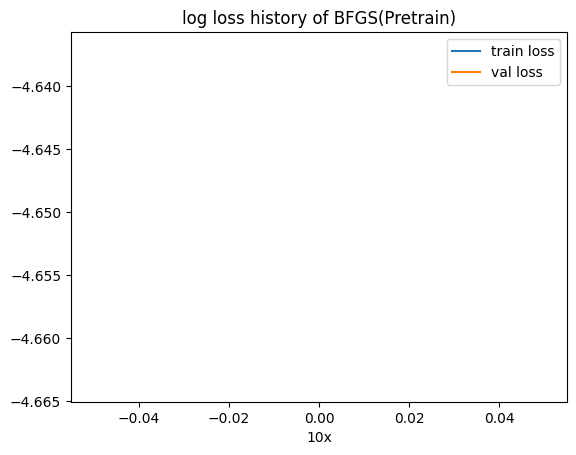

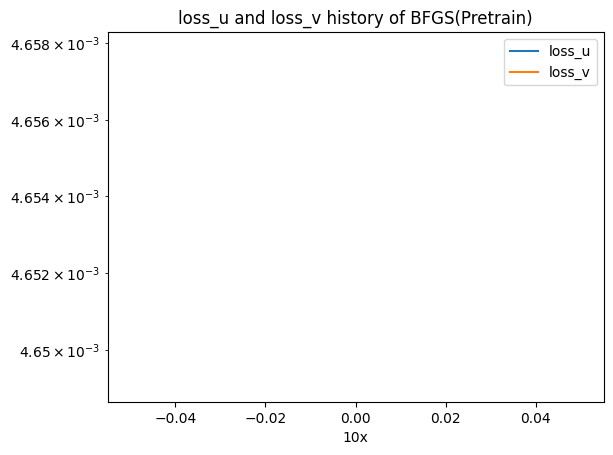

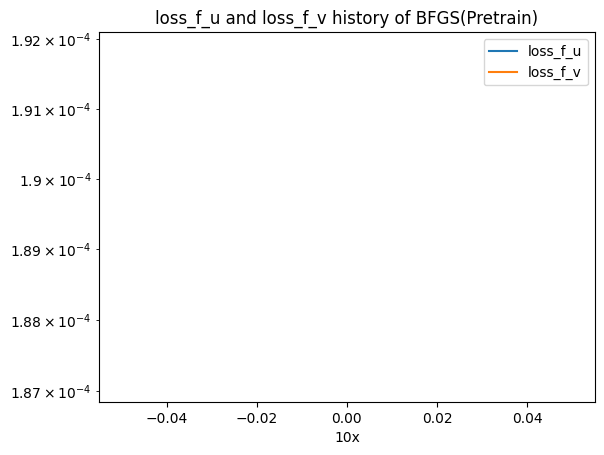

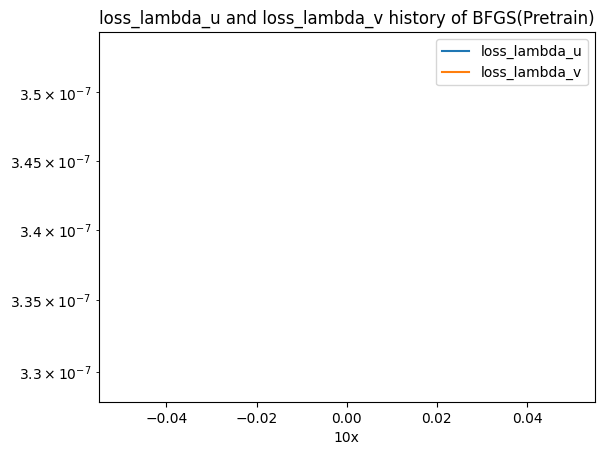

In [11]:
######################## Plots for L-BFGS-B(Pretraining) #################
fig = plt.figure()
plt.plot(loss_history_Pretrain)
plt.plot(loss_val_history_Pretrain)
plt.legend(('train loss', 'val loss'))
plt.xlabel('10x')
plt.title('log loss history of BFGS(Pretrain)')  
plt.savefig('figures/5.png')

fig = plt.figure()
plt.plot(loss_u_history_Pretrain)
plt.plot(loss_v_history_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_u', 'loss_v'))
plt.title('loss_u and loss_v history of BFGS(Pretrain)')  
plt.savefig('figures/6.png')

fig = plt.figure()
plt.plot(loss_f_u_history_Pretrain)
plt.plot(loss_f_v_history_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of BFGS(Pretrain)')     
plt.savefig('figures/7.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history_Pretrain)
plt.plot(loss_lambda_v_history_Pretrain)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of BFGS(Pretrain)') 
plt.savefig('figures/8.png')

##  Plots for Adam

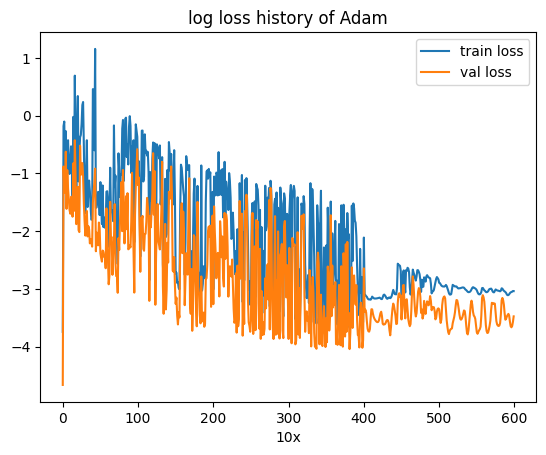

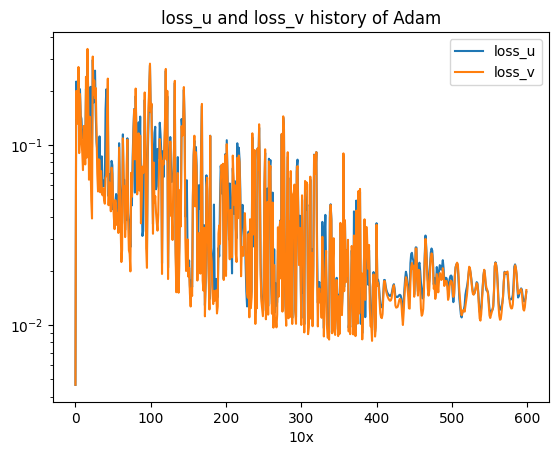

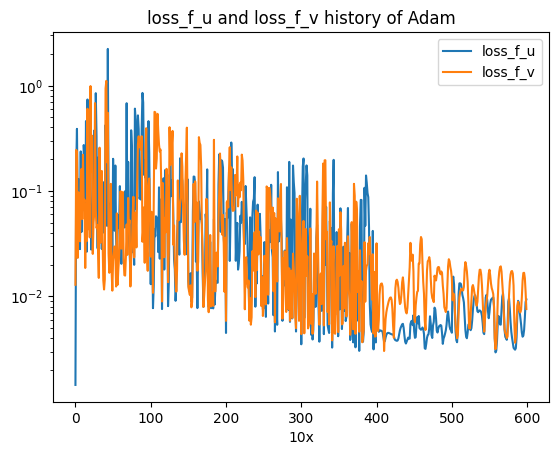

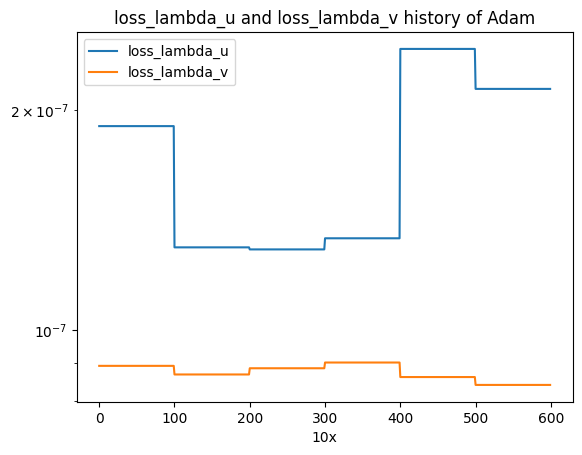

In [12]:
######################## Plots for Adam #################
fig = plt.figure()
plt.plot(loss_history_Adam)
plt.plot(loss_val_history_Adam)
plt.legend(('train loss', 'val loss'))
plt.xlabel('10x')
plt.title('log loss history of Adam')
plt.savefig('figures/9.png')

fig = plt.figure()
plt.plot(loss_u_history_Adam)
plt.plot(loss_v_history_Adam)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_u', 'loss_v'))
plt.title('loss_u and loss_v history of Adam')  
plt.savefig('figures/10.png')

fig = plt.figure()
plt.plot(loss_f_u_history_Adam)
plt.plot(loss_f_v_history_Adam)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of Adam') 
plt.savefig('figures/11.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history_Adam)
plt.plot(loss_lambda_v_history_Adam)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of Adam')
plt.savefig('figures/12.png')

##  Plots for BFGS

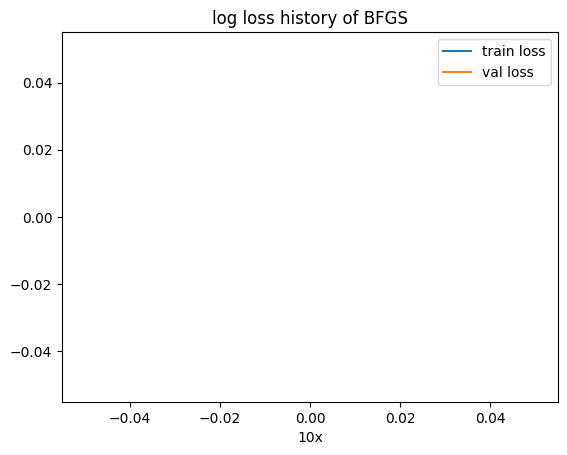

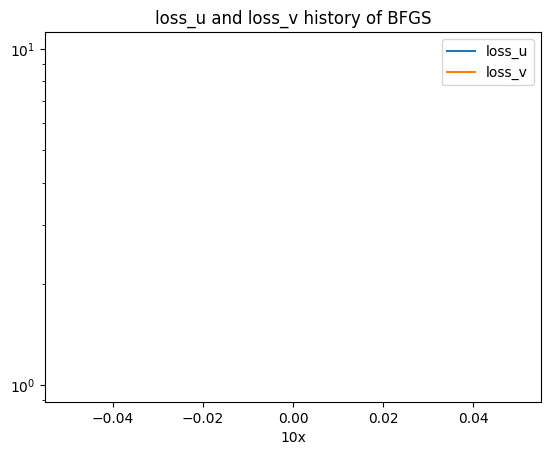

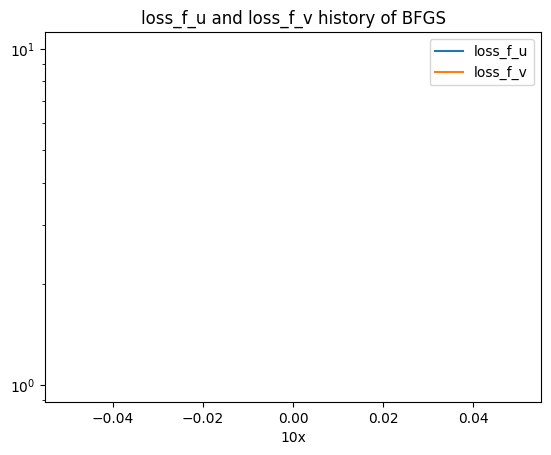

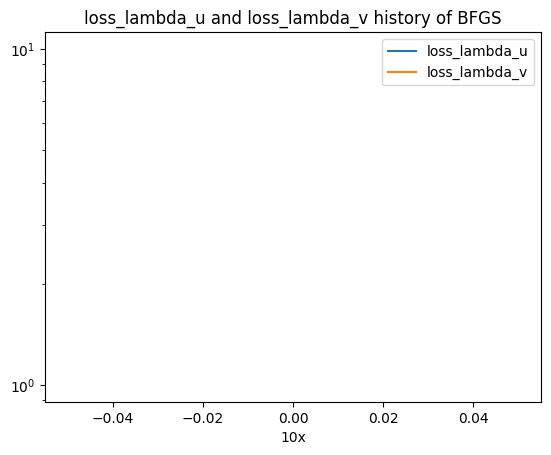

In [13]:
######################## Plots for BFGS #################
fig = plt.figure()
plt.plot(loss_history)
plt.plot(loss_val_history)
plt.legend(('train loss', 'val loss'))
plt.xlabel('10x')
plt.title('log loss history of BFGS')  
plt.savefig('figures/13.png')

fig = plt.figure()
plt.plot(loss_u_history)
plt.plot(loss_v_history)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_u', 'loss_v'))
plt.title('loss_u and loss_v history of BFGS')  
plt.savefig('figures/14.png')

fig = plt.figure()
plt.plot(loss_f_u_history)
plt.plot(loss_f_v_history)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of BFGS')     
plt.savefig('figures/15.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history)
plt.plot(loss_lambda_v_history)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of BFGS')  
plt.savefig('figures/16.png')

## Plots for STRidge

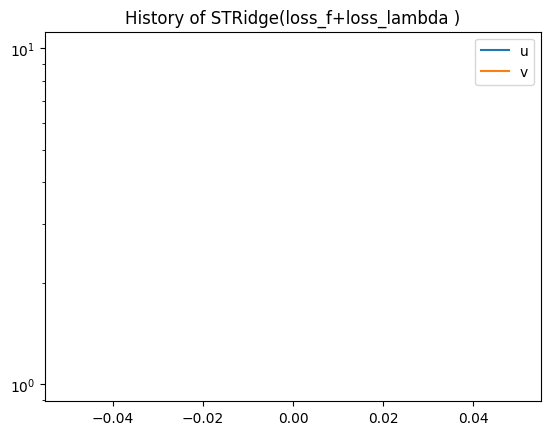

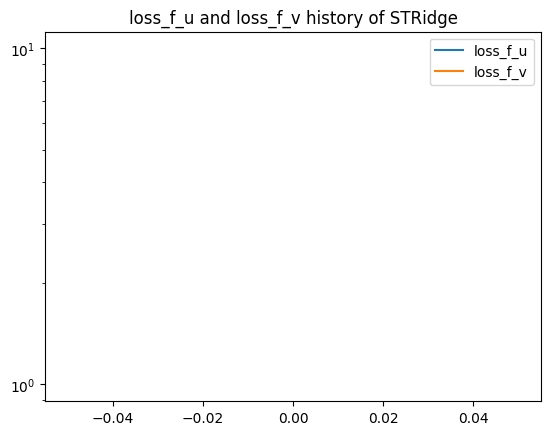

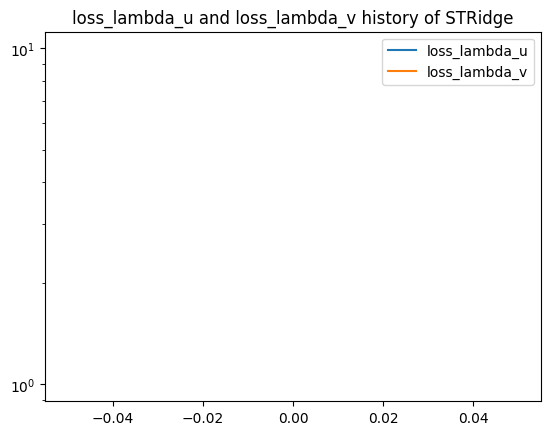

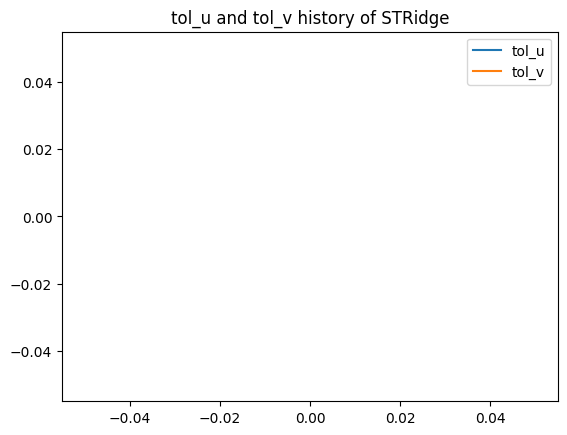

In [14]:
######################## Plots for STRidge #################        
fig = plt.figure()
plt.plot(loss_u_history_STRidge)
plt.plot(loss_v_history_STRidge)
plt.yscale('log')       
plt.legend(('u', 'v'))
plt.title('History of STRidge(loss_f+loss_lambda )')  
plt.savefig('figures/17.png')

fig = plt.figure()
plt.plot(loss_f_u_history_STRidge)
plt.plot(loss_f_v_history_STRidge)
plt.yscale('log')       
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of STRidge') 
plt.savefig('figures/18.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history_STRidge)
plt.plot(loss_lambda_v_history_STRidge)
plt.yscale('log')      
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of STRidge')  
plt.savefig('figures/19.png')

fig = plt.figure()
plt.plot(tol_u_history_STRidge)
plt.plot(tol_v_history_STRidge)
plt.legend(('tol_u', 'tol_v'))
plt.title('tol_u and tol_v history of STRidge')  
plt.savefig('figures/20.png')

##  Plots for Alter

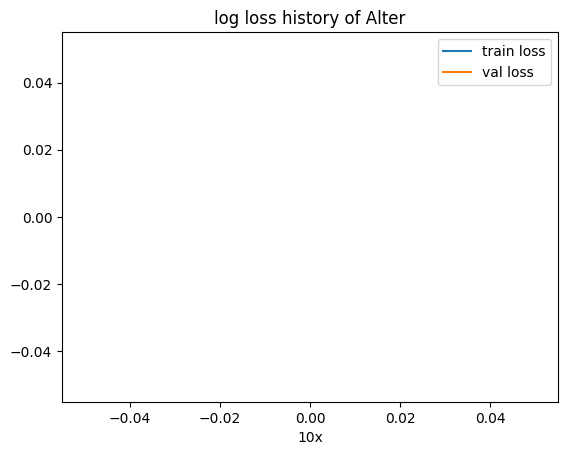

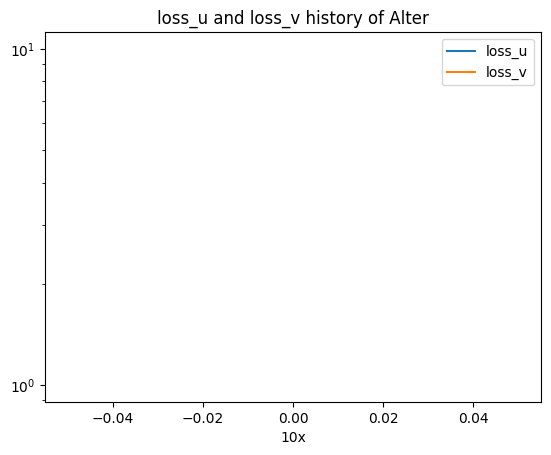

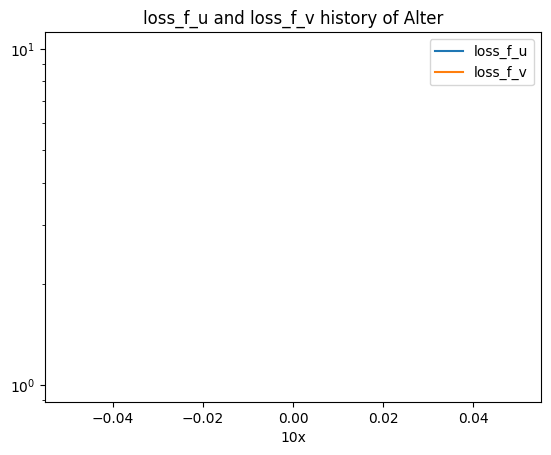

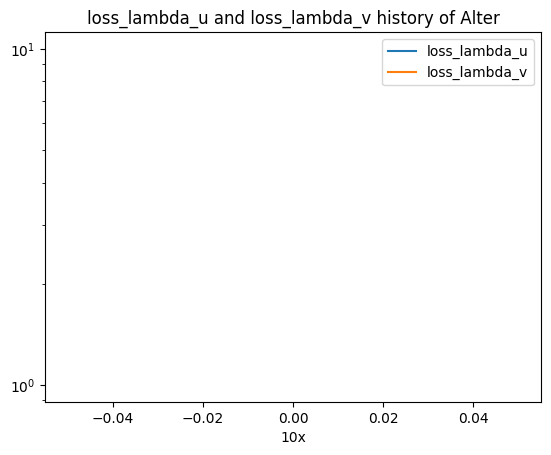

In [15]:
######################## Plots for Alter #################
fig = plt.figure()
plt.plot(loss_history_Alter)
plt.plot(loss_val_history_Alter)
plt.legend(('train loss', 'val loss'))
plt.xlabel('10x')
plt.title('log loss history of Alter')
plt.savefig('figures/21.png')

fig = plt.figure()
plt.plot(loss_u_history_Alter)
plt.plot(loss_v_history_Alter)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_u', 'loss_v'))
plt.title('loss_u and loss_v history of Alter')  
plt.savefig('figures/22.png')

fig = plt.figure()
plt.plot(loss_f_u_history_Alter)
plt.plot(loss_f_v_history_Alter)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_f_u', 'loss_f_v'))
plt.title('loss_f_u and loss_f_v history of Alter') 
plt.savefig('figures/23.png')

fig = plt.figure()
plt.plot(loss_lambda_u_history_Alter)
plt.plot(loss_lambda_v_history_Alter)
plt.yscale('log')       
plt.xlabel('10x')
plt.legend(('loss_lambda_u', 'loss_lambda_v'))
plt.title('loss_lambda_u and loss_lambda_v history of Alter')  
plt.savefig('figures/24.png')

## Lambda u and v calculations

In [16]:
# =============================================================================
#       Compare with ground truth if training efforts are sufficient      
# =============================================================================
# u
lambda_u_value = model.lambda_u.cpu().detach().numpy().flatten()    
lambda_u_true = np.zeros((110,1))
lambda_u_true[2] = -0.1 # -0.1*u_xx
lambda_u_true[4] = -0.1 # -0.1*u_yy
lambda_u_true[11] = -1 # -u   
lambda_u_true[33] = 1 # u^3
lambda_u_true[66] = -1 # -v^3
lambda_u_true[88] = 1 # u*v^2
lambda_u_true[99] = -1 # -u^2*v
lambda_u_true = -lambda_u_true.flatten() # Note that there's a negative sign due to the different calculation in net_f.

cosine_similarity_u = 1-distance.cosine(lambda_u_true,lambda_u_value)
f.write('\nCosine similarity of lambda_u: %.2f \n' % (cosine_similarity_u))
error_lambda_u = np.linalg.norm(lambda_u_true-lambda_u_value,2)/np.linalg.norm(lambda_u_true,2)
f.write('lambda_u Error: %.2f \n' % (error_lambda_u))
nonzero_ind_u = np.nonzero(lambda_u_true)
lambda_u_error_vector = np.absolute((lambda_u_true[nonzero_ind_u]-lambda_u_value[nonzero_ind_u])/lambda_u_true[nonzero_ind_u])
error_lambda_u_mean = np.mean(lambda_u_error_vector)
error_lambda_u_std = np.std(lambda_u_error_vector)
f.write('lambda_u Mean Error: %.4f \n' % (error_lambda_u_mean))
f.write('lambda_u Std Error: %.4f \n' % (error_lambda_u_std))

disc_eq_temp = []
for i_lib in range(len(lib_descr)):
    if lambda_u_value[i_lib] != 0:
        disc_eq_temp.append(str(lambda_u_value[i_lib]) + lib_descr[i_lib])

        
disc_eq_u = '+'.join(disc_eq_temp)        
f.write('The discovered equation: u_t = ' + disc_eq_u)

# v
lambda_v_value = model.lambda_v.cpu().detach().numpy().flatten() 
lambda_v_true = np.zeros((110,1))
lambda_v_true[7] = -0.1 # -0.1*v_xx
lambda_v_true[9] = -0.1 # -0.1*v_yy
lambda_v_true[33] = 1 # u^3
lambda_v_true[44] = -1 # -v
lambda_v_true[66] = 1 # v^3
lambda_v_true[88] = 1 # u*v^2
lambda_v_true[99] = 1 # u^2*v      
lambda_v_true = -lambda_v_true.flatten()  # Note that there's a negative sign due to the different calculation in net_f.
cosine_similarity_v = 1-distance.cosine(lambda_v_true,lambda_v_value)
f.write('Cosine similarity of lambda_v: %.2f \n' % (cosine_similarity_v))
error_lambda_v = np.linalg.norm(lambda_v_true-lambda_v_value,2)/np.linalg.norm(lambda_v_true,2)
f.write('lambda_v Error: %.2f \n' % (error_lambda_v))
nonzero_ind_v = np.nonzero(lambda_v_true)
lambda_v_error_vector = np.absolute((lambda_v_true[nonzero_ind_v]-lambda_v_value[nonzero_ind_v])/lambda_v_true[nonzero_ind_v])
error_lambda_v_mean = np.mean(lambda_v_error_vector)
error_lambda_v_std = np.std(lambda_v_error_vector)
f.write('lambda_v Mean Error: %.4f \n' % (error_lambda_v_mean))
f.write('lambda_v Std Error: %.4f \n' % (error_lambda_v_std))

lambda_total_error_vector = np.concatenate((lambda_u_error_vector, lambda_v_error_vector))
error_lambda_total_mean = np.mean(lambda_total_error_vector)
error_lambda_total_std = np.std(lambda_total_error_vector)
f.write('lambda_total Mean Error: %.4f \n' % (error_lambda_total_mean))
f.write('lambda_total Std Error: %.4f \n' % (error_lambda_total_std))

disc_eq_temp = []
for i_lib in range(len(lib_descr)):
    if lambda_v_value[i_lib] != 0:
        disc_eq_temp.append(str(lambda_v_value[i_lib]) + lib_descr[i_lib])

disc_eq_v = '+'.join(disc_eq_temp)        
f.write('The discovered equation: v_t = ' + disc_eq_v)
f.close()






## Plots for lambdas

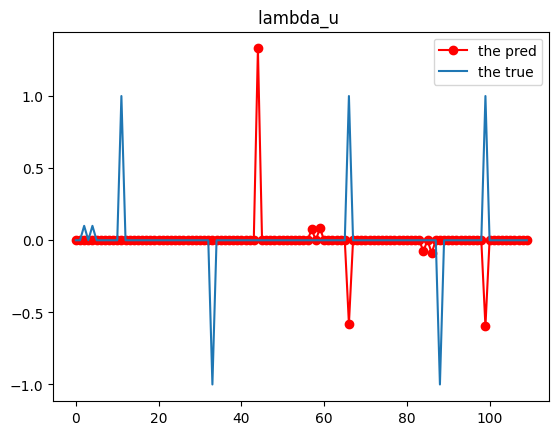

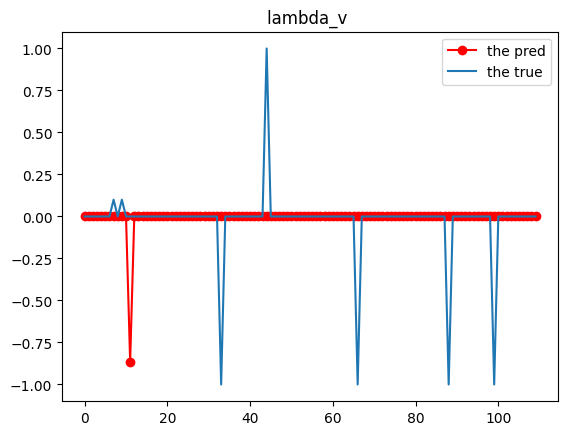

In [17]:
######################## Plots for lambdas #################
fig = plt.figure()
plt.plot(lambda_u_value, 'ro-')
plt.plot(lambda_u_true)
plt.legend(('the pred', 'the true'))
plt.title('lambda_u ')
plt.savefig('figures/25.png')

fig = plt.figure()
plt.plot(lambda_v_value, 'ro-')
plt.plot(lambda_v_true)
plt.legend(('the pred', 'the true'))
plt.title('lambda_v ')        
plt.savefig('figures/26.png')

# Saving results to disk

In [18]:
scipy.io.savemat('out_data/DiscLam_ADO.mat', {'Lamu_True': lambda_u_true, 'Lamu_Disc': lambda_u_value,
                                 'Lamv_True': lambda_v_true, 'Lamv_Disc': lambda_v_value})

u_pred_full, v_pred_full = model.predict(X_star_train)        
scipy.io.savemat('PredResponse_full.mat', {'u_pred_full':u_pred_full, 'v_pred_full':v_pred_full})

scipy.io.savemat('out_data/History.mat', {'lambda_u_history_Adam_Pretrain':lambda_u_history_Adam_Pretrain,
                                 'lambda_v_history_Adam_Pretrain':lambda_v_history_Adam_Pretrain,
                                 'lambda_u_history_Pretrain': lambda_u_history_Pretrain,
                                 'lambda_v_history_Pretrain': lambda_v_history_Pretrain,
                                 'lambda_u_history_Alter': lambda_u_history_Alter,
                                 'lambda_v_history_Alter': lambda_v_history_Alter,
                                 'lambda_u_history_STRidge': lambda_u_history_STRidge,
                                 'ridge_u_append_counter_STRidge': ridge_u_append_counter_STRidge,
                                 'lambda_v_history_STRidge': lambda_v_history_STRidge,
                                 'ridge_v_append_counter_STRidge': ridge_v_append_counter_STRidge,
                                 'loss_history_Adam_Pretrain': loss_history_Adam_Pretrain,
                                 'loss_history_BFGS_Pretrain': loss_history_Pretrain,
                                 'loss_history_Adam': loss_history_Adam,
                                 'loss_history_BFGS': loss_history,
                                 'loss_val_history_Adam_Pretrain': loss_val_history_Adam_Pretrain,
                                 'loss_val_history_BFGS_Pretrain': loss_val_history_Pretrain,
                                 'loss_val_history_Adam': loss_val_history_Adam,
                                 'loss_val_history': loss_val_history
                                 })
